<font size="+3" style="font-weight:bold;">
    Whatsapp Chat Analysis
</font>

In [1]:
import textwrap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import emojis  # pip install emojis
from collections import Counter

# Make figure access visible with dark theme: https://stackoverflow.com/a/55436299
plt.rcParams['figure.facecolor'] = 'white'

pd.set_option('display.max_rows', 500)

# Set seaborn default style
sns.set()

pair_palette = sns.color_palette("Paired")


In [2]:
# Constants

# Unfortunately, Whatsapp chat export uses the date format of the OS
date_format = '%m/%d/%y, %H:%M'
anonymize = True
textfile = 'data/whatsapp-chat.txt'

# Limit analysis to a date range
date_min = None
#date_max = None
date_max = '2017-12-30'

# Data import and preprocessing

In [3]:
# See https://towardsdatascience.com/complete-beginners-guide-to-processing-whatsapp-data-with-python-781c156b5f0b
def read_file(file: str) -> list[str]:
    """Reads Whatsapp text file into a list of strings"""
    file = open(file, 'r', encoding = 'utf-8') #Opens the text file into variable x but the variable cannot be explored yet
    content = file.read( ) #By now it becomes a huge chunk of string that we need to separate line by line
    lines = content.splitlines() #The splitline method converts the chunk of string into a list of strings
    return lines

lines = read_file(textfile)
len(lines)

2518

In [4]:
def filter_lines(lines: list[str]) -> list[str]:
    # Create copy
    lines = list(lines)
    
    # Handle multiline messages
    i_message = 0  # Marks index of message start (a message may contain multiple lines
    for i in range(len(lines)):
        try:
            datetime.strptime(lines[i].split(' - ')[0], date_format) #Converts string date into a date object
            i_message = i
        except ValueError: # Returns an error if the string is not a datetime object
            lines[i_message] = lines[i_message] + ' ' + lines[i]
            lines[i] = 'NA'  # Replace the unwanted text element with 'NA'

    lines = [line for line in lines if line != 'NA']
    
    return lines

lines = filter_lines(lines)
len(lines)

2496

In [5]:
def get_chat_dataframe(lines: list[str]) -> pd.DataFrame:
    removed_lines: list[str] = []
    dates = []
    authors = []
    messages = []
    for line in lines:
        try:
            date, rest = line.split(' - ', 1)
            author, message = rest.split(': ', 1)
            dates.append(datetime.strptime(date, date_format))
            authors.append(author)
            messages.append(message)
        except ValueError:
            removed_lines.append(line)

    print(f'{len(removed_lines)} lines removed')
    print(*removed_lines, sep = "\n")

    return pd.DataFrame(list(zip(dates, authors, messages)), columns = ['date', 'author', 'message'])

df = get_chat_dataframe(lines)

1 lines removed
4/6/16, 02:36 - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.


In [6]:
# Limit time range
if date_min is not None:
    df = df[df['date'] >= date_min]
if date_max is not None:
    df = df[df['date'] <= date_max]


In [7]:
# Convert author column to ordered categorical
df['author'] = df['author'].astype('category')

# Anonymize
if anonymize:
    codes = df['author'].cat.codes + 1
    df['author'] = ('Person ' + codes.astype(str)).astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301 entries, 0 to 2300
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2301 non-null   datetime64[ns]
 1   author   2301 non-null   category      
 2   message  2301 non-null   object        
dtypes: category(1), datetime64[ns](1), object(1)
memory usage: 56.3+ KB


# General message statistics

Who writes how many messages and how long are they? Some people tend to write more messages, but shorter
ones and vice versa.

## Message count

In [9]:
# Build aggregate dataframe by joining aggregate columns step by step and use it for plotting.
df_agg = df.groupby('author').agg(
    message_count=('date', 'size'),  # Row count per group (column name irrelevant)
)
df_agg


,message_count
author,
Person 1,795
Person 2,1506


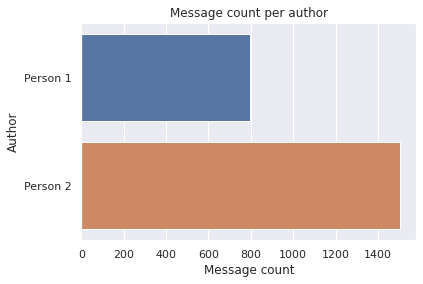

In [10]:
sns.barplot(x=df_agg['message_count'], y=df_agg.index)
plt.title('Message count per author')
plt.xlabel('Message count')
plt.ylabel('Author')
plt.show()

## Total characters typed

The amount of characters typed is a better indicator for activity than the number of messages.

In [11]:
# Some emojis will be counted as two characters, but that's ok
df['length'] = df['message'].str.len()
df_agg = df_agg.join(
    # This way of aggregating gives best control over resulting column names
    df.groupby('author').agg(
        length_sum=('length', 'sum'),
        length_mean=('length', 'mean'),
    )
)
df_agg

,message_count,length_sum,length_mean
author,,,
Person 1,795,39761,50.013836
Person 2,1506,50497,33.530544


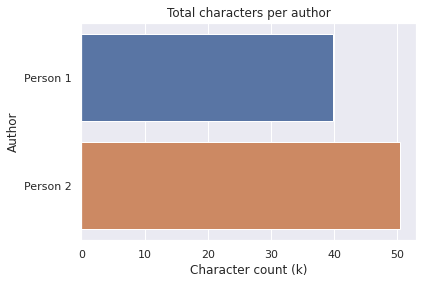

In [12]:
sns.barplot(x=df_agg['length_sum'] / 1000, y=df_agg.index)
plt.title('Total characters per author')
plt.xlabel('Character count (k)')
plt.ylabel('Author')
plt.show()

## Average message length per author

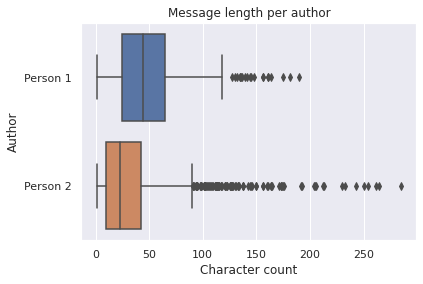

In [13]:
sns.boxplot(x="length", y="author", data=df[df['length'] <= 500])
plt.title('Message length per author')
plt.xlabel('Character count')
plt.ylabel('Author')
plt.show()

# Emojis

Which and how many emojis are used?

## Emoji count per message

Some people repeat the same emoji for emphasis, therefore we calculate emoji frequency and _unique_ emoji frequency.

In [14]:
df['emojis'] = df.apply(lambda row: emojis.count(row['message']), axis=1)
df['emojis_unique'] = df.apply(lambda row: emojis.count(row['message'], unique=True), axis=1)

df_agg = df_agg.join(
    df.groupby('author').agg(
        emojis_sum=('emojis', 'sum'),
        emojis_unique_sum=('emojis_unique', 'sum'),
    )
)
df_agg['emojis_freq'] = df_agg['emojis_sum'] / df_agg['length_sum']
df_agg['emojis_unique_freq'] = df_agg['emojis_unique_sum'] / df_agg['length_sum']
df_agg

,message_count,length_sum,length_mean,emojis_sum,emojis_unique_sum,emojis_freq,emojis_unique_freq
author,,,,,,,
Person 1,795,39761,50.013836,338,305,0.008501,0.007671
Person 2,1506,50497,33.530544,351,321,0.006951,0.006357


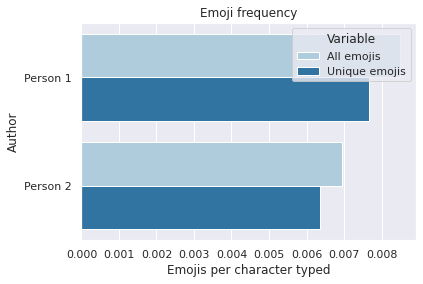

In [15]:
# Grouped bar chart, see https://stackoverflow.com/a/38611976/94289
df_emoji = pd.melt(df_agg.reset_index(), id_vars=['author'], value_vars=['emojis_freq', 'emojis_unique_freq'])
df_emoji['variable'].replace(['emojis_freq', 'emojis_unique_freq'], ['All emojis', 'Unique emojis'], inplace=True)
sns.barplot(x='value', y='author', hue='variable', data=df_emoji, palette=pair_palette)
plt.title('Emoji frequency')
plt.xlabel('Emojis per character typed')
plt.ylabel('Author')
# Using labels parameter breaks legend patches (seaborn bug?), therefore variables are renamed in dataframe above.
plt.legend(title='Variable')
plt.show()

## Emoji types

In [16]:
emoji_counters = {}
for author, df_group in df.groupby('author'):
    emoji_counter = Counter()
    for row_index, row in df_group.iterrows():
        # Will count unique emojis per message, so emoji repetitions are ignored.
        emoji_counter.update(emojis.get(row['message']))

    emoji_counters[author] = emoji_counter

In [17]:
for author, counter in emoji_counters.items():
    print(author)
    print('Most common: ', *counter.most_common(5))
    print('Emojis used: ', len(counter))
    emoji_list = [emoji for emoji, count in counter.most_common()]
    print('Emojis ordered by frequency:', textwrap.fill(''.join(emoji_list), 50), sep='\n')
    print()

Person 1
Most common:  ('😊', 104) ('😃', 50) ('😜', 40) ('😘', 35) ('😥', 14)
Emojis used:  41
Emojis ordered by frequency:
😊😃😜😘😥😁😋😱😈😉🌞😳😰😝🙃😂😣🙈🌛🇨🇭🎄✨⭐😔💊👻🙄😆😩🍰😤😟😨😅😕🐱👵🍺😓😞😒

Person 2
Most common:  ('😊', 27) ('😉', 23) ('😘', 20) ('😂', 15) ('😃', 15)
Emojis used:  66
Emojis ordered by frequency:
😊😉😘😂😃😩😱😳👌😅😍😋😀🙈😞😚😜😁😒😓😆😫😙😄🙉👏😔💃👍😛👋😨😥🔫😪🙏😏😟🌎💪⏰⏳😭😌😝😕👠🌹😎😣
😢💊😽🎂🎄😦🎉🏃🍕🤗😤👮😡🐱👵😮



# Reaction times

Who tends to respond faster?

In [18]:
# Only keep rows if author changes, see https://stackoverflow.com/a/24944639/94289
df['author_change'] = False
df.loc[df['author'] != df['author'].shift(1), 'author_change'] = True
date_delta = df['date'].diff()
df.loc[df['author_change'], 'reaction_delta'] = date_delta
df['reaction_minutes'] = df['reaction_delta'].dt.total_seconds() // 60
df.drop(columns='message').head()

,date,author,length,emojis,emojis_unique,author_change,reaction_delta,reaction_minutes
0,2014-07-31 02:26:00,Person 1,3,0,0,True,NaT,NaN
1,2014-07-31 02:26:00,Person 1,8,0,0,False,NaT,NaN
2,2014-07-31 03:13:00,Person 2,3,3,3,True,0 days 00:47:00,47.0
3,2014-07-31 03:25:00,Person 1,24,0,0,True,0 days 00:12:00,12.0
4,2014-07-31 03:26:00,Person 2,7,0,0,True,0 days 00:01:00,1.0


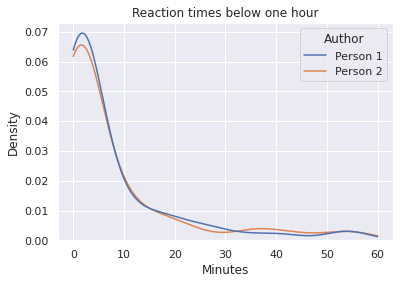

In [19]:
reaction_min = 0
reaction_max = 1*60  # Cutoff (minutes) for reaction times
reaction_mask = df['reaction_minutes'].between(reaction_min, reaction_max)

# Normalize each distribution separately (common_norm=False), so message count doesn't increase peak
g = sns.kdeplot(x=df[reaction_mask]['reaction_minutes'], hue=df['author'], common_norm=False, clip=(reaction_min, reaction_max))
plt.title('Reaction times below one hour')
plt.xlabel('Minutes')
# g._legend.set_title('Author') # Change legend title for plots based on Grid class (e.g. displot): https://stackoverflow.com/a/45211976/94289
# plt.legend(title='Author')
g.axes.get_legend().set_title('Author')
plt.show()

# Contact initiation

Who initiates contact more on a new day?

In [20]:
# Mark first message of day
# Set day start at 5am
hour_delta = pd.Timedelta(hours=5)
df['first_of_day'] = False
first_idx = df.groupby((df['date'] - hour_delta).dt.date)['date'].idxmin()
df.loc[first_idx, 'first_of_day'] = True
break_hours = 48
df['first_after_break'] = df['reaction_delta'] >= timedelta(hours=break_hours)

In [21]:

df_agg = df_agg.join(
    df.groupby('author').agg(
        first_of_day_count=('first_of_day', 'sum'),
        first_after_break_count=('first_after_break', 'sum'),
    )
)
df_agg

,message_count,length_sum,length_mean,emojis_sum,emojis_unique_sum,emojis_freq,emojis_unique_freq,first_of_day_count,first_after_break_count
author,,,,,,,,,
Person 1,795,39761,50.013836,338,305,0.008501,0.007671,99,41
Person 2,1506,50497,33.530544,351,321,0.006951,0.006357,79,8


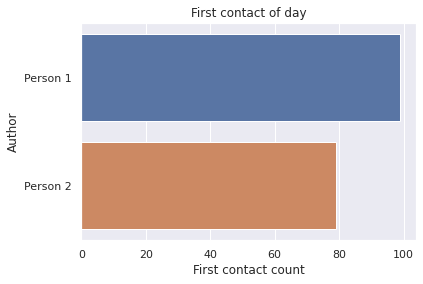

In [22]:
sns.barplot(x=df_agg['first_of_day_count'], y=df_agg.index)
plt.title('First contact of day')
plt.xlabel('First contact count')
plt.ylabel('Author')
plt.show()

Who initiates contact more after silence?

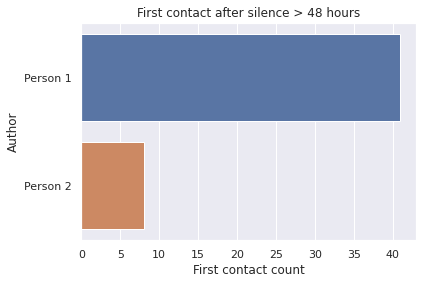

In [23]:
sns.barplot(x=df_agg['first_after_break_count'], y=df_agg.index)
plt.title(f'First contact after silence > {break_hours} hours')
plt.xlabel('First contact count')
plt.ylabel('Author')
plt.show()


# Activity

How active was the communication?

In [24]:
# Sum of typed characters per author per day
chars_per_day = pd.DataFrame(df.groupby([df['author'], df['date'].dt.date])['length'].sum())


In [25]:
# Resample to daily frequency
resampled = df.set_index('date').groupby('author')['length'].resample('D')
# Join multiindex dataframes: https://stackoverflow.com/a/27925360/94289
# ffill() will fill in date gaps
df_activity = pd.DataFrame(resampled.sum().ffill()).join(pd.DataFrame(resampled.size().ffill()), rsuffix='a')
df_activity.columns = ['length_sum', 'message_count']
# Author and date as separate columns instead of multi index
df_activity.reset_index(inplace=True)
df_activity.head(3)

,author,date,length_sum,message_count
0,Person 1,2014-07-31,306,7
1,Person 1,2014-08-01,0,0
2,Person 1,2014-08-02,0,0


In [26]:
# Daily activity aggregated over authors
df_total_activity = df_activity.groupby('date').sum()
days_count = len(df_total_activity)
activity_days_count = len(df_total_activity[df_total_activity['message_count'] > 0])
no_activity_days_count = days_count - activity_days_count
activity_days_percent = round(activity_days_count / days_count * 100)

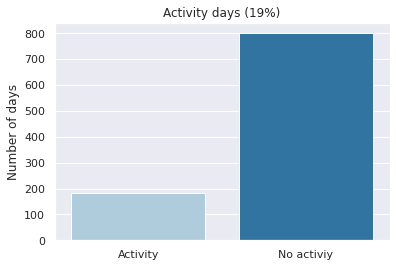

In [27]:
sns.barplot(x=['Activity', 'No activiy'], y=[activity_days_count, no_activity_days_count], palette=pair_palette)
plt.title(f'Activity days ({activity_days_percent}%)')
plt.ylabel('Number of days')
plt.show()

In [28]:
print(f'Messages were sent on {activity_days_count} of {len(df_total_activity)} days ({activity_days_percent}%)')

Messages were sent on 183 of 983 days (19%)


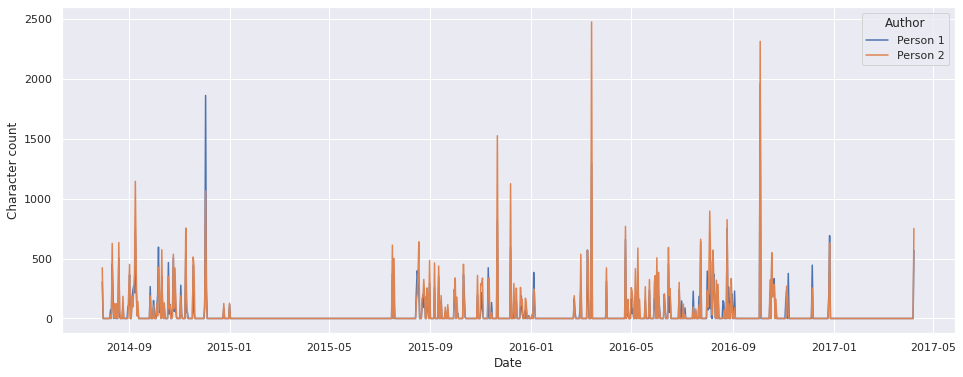

In [29]:
plt.figure(figsize=(16, 6))
sns.lineplot(x='date', y='length_sum', data=df_activity, hue='author')
plt.xlabel('Date')
plt.ylabel('Character count')
plt.legend(title='Author')
plt.show()

# Word cloud


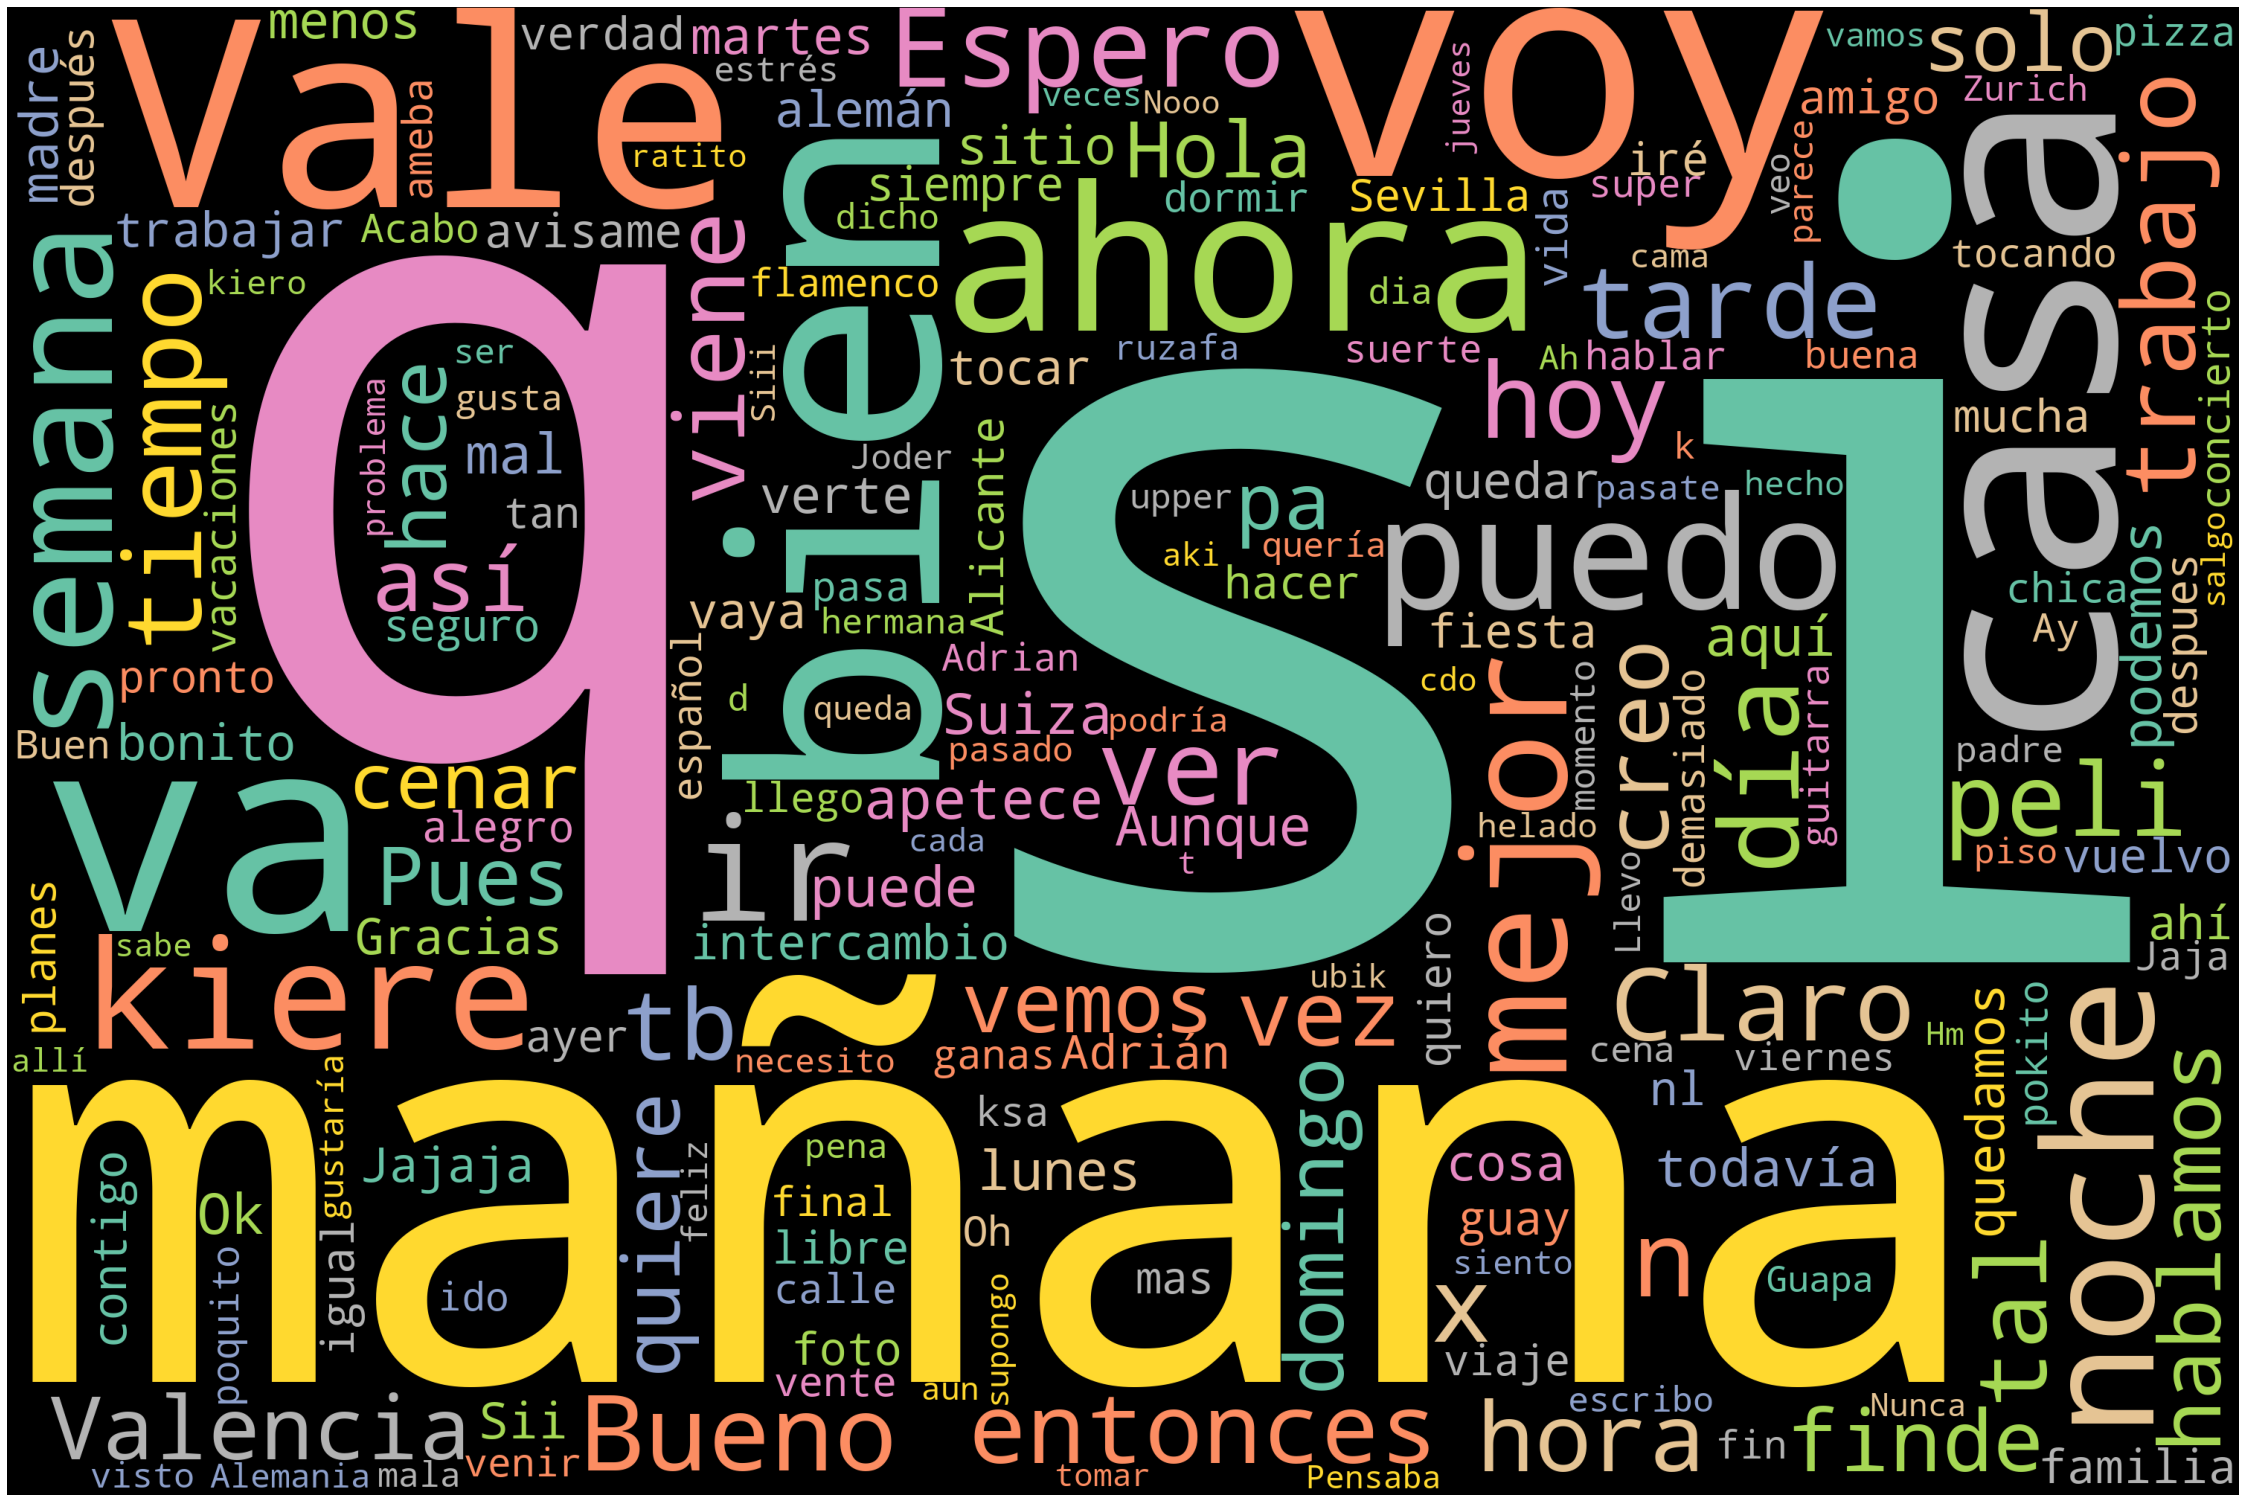

In [30]:
from wordcloud import WordCloud  # pip install wordcloud
from stop_words import get_stop_words  # pip install stop-words
import re

def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off")

# Generate word cloud
custom_stop_words = ['media', 'omitted']
stop_words = get_stop_words('en') + get_stop_words('de') + get_stop_words('es') + custom_stop_words

text = df['message'].str.cat(sep=' ')
text = re.sub(r'http\S+', '', text)  # Remove urls
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2',
                      collocations=False, stopwords = stop_words).generate(text)
# Plot
plot_cloud(wordcloud)


In [32]:
# Export notebook as html with TOC, see https://stackoverflow.com/a/59286150/94289
!jupyter nbconvert --no-prompt --to html_toc --ExtractOutputPreprocessor.enabled=False whatsapp-chat-analysis.ipynb
# !jupyter nbconvert --no-input --no-prompt boomerang.ipynb


[NbConvertApp] Converting notebook whatsapp-chat-analysis.ipynb to html_toc
[NbConvertApp] Writing 2129643 bytes to whatsapp-chat-analysis.html
